<a href="https://colab.research.google.com/github/ravindrabharathi/diabetic-retinopathy/blob/master/Diabetic_Retinopathy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Detection of Diabetic Retinopathy using Deep Learning 

We will use Convolutional Neural Networks to classify if an image of Retina shows signs of Diabetic Retinopathy 

Diabetic Retinopathy afflicts a large poulation and mostly becomes severe , even leading to blindness, due to lack of access to easily accessible detection tools in rural areas. By training a deep learning model to detect Retinopathy from images , we could make a mobile application available for a primary health care center or an NGO who can then use it do preliminary screening once they have the means to capture retinal images. 

For initial exploration we will use a Dataset from https://ieee-dataport.org/open-access/indian-diabetic-retinopathy-image-dataset-idrid

This dataset contains 413 Training images and 103 Test images .The GroundTruth labels are present for Retinopathy and macular edema risk. Right now we will focus on retinopathy classification( 5 classes) . Once we have formed a strategy , we will switch to bigger datasets which will help us train a better performing model 


We will use Keras with tensorflow for this . In the next stages we could use this library https://github.com/ravindrabharathi/tf_utils. This library is a work in progress but it already gives us the ability to build an input data pipeline using TfRecords, tf.Data Datasets , augmentation strategies like cutout , random-pad-crop, the ability to plot misclassified images and also ability to plot confusion matrix 



#import necessary modules 

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Concatenate,Lambda,Activation,Input

from tensorflow.keras.optimizers import Adam,SGD

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline



#Exploratory analysis and Pre-processing Data 

Do an initial exploration of how the images look and if we need to process them in any way 

function to crop image 

In [0]:
def crop_img(img):
  shp=img.shape
  #print(shp)
  x1=shp[1]//12
  x2=x1+shp[0]+350
  
  img1=img[:,x1:x2,:]
  #print(img1.shape)
  return img1

In [0]:
!mkdir 'resized'

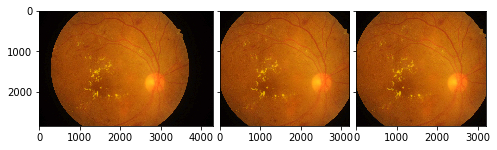

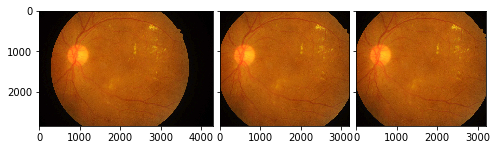

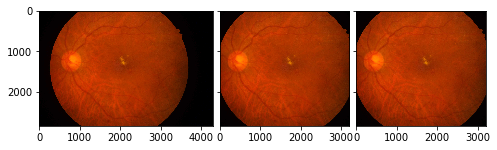

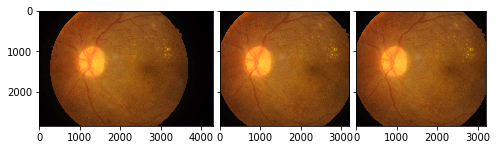

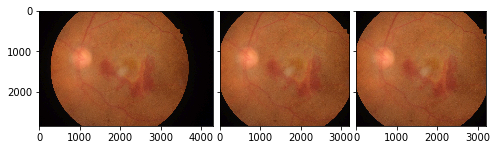

In [0]:

for i in range(5):
  image_path='./IDRiD_00'+str(i+1)+'.jpg'
  save_path='./resized/IDRiD_00'+str(i+1)+'.jpg'
  image=plt.imread(image_path)
  #print(image.shape)
  image2=crop_img(image)
  plt.imsave(save_path,image2)
  image3=plt.imread(save_path)

  fig = plt.figure(figsize=(8., 8.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  
                 axes_pad=0.1,  # pad between axes in inch.
                 )

  for ax, im in zip(grid, [image, image2,image3]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

  plt.show()
  


Above are original image and cropped image . The last image in every row is plotted by reading the saved iage just to make sure we havent lost information the process 

### Mount google drive to get the dataset 

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
!cp -r '/gdrive/My Drive/d-i/retinopathy/' './data/'

### utility functions for appending proper file extension  and casting labels to string 

In [0]:
def set_file_ext(val):
  return str(val)+'.jpg'

def cast_str(val):
  return str(val)  

### Read the label data for training data set and inspect the first few rows  

In [0]:
train_data=pd.read_csv('./data/labels/train_labels.csv', header=0)
train_data.head()


Image name  Retinopathy grade  ...  Unnamed: 10  Unnamed: 11
0  IDRiD_001                  3  ...          NaN          NaN
1  IDRiD_002                  3  ...          NaN          NaN
2  IDRiD_003                  2  ...          NaN          NaN
3  IDRiD_004                  3  ...          NaN          NaN
4  IDRiD_005                  4  ...          NaN          NaN

[5 rows x 12 columns]

### clean up the label training label data as it contains a lot of unnecessary additional columns created due to the extra ',' separators in the label file .

In [0]:
train_data = train_data.loc[:, ~train_data.columns.str.contains('^Unnamed')]
train_data.head()

Image name  Retinopathy grade  Risk of macular edema 
0  IDRiD_001                  3                       2
1  IDRiD_002                  3                       2
2  IDRiD_003                  2                       2
3  IDRiD_004                  3                       2
4  IDRiD_005                  4                       0

### Rename the column names to shorter ones to make it easier for ourselves.
### The data also has macular edema risk ground truth values . We could drop it if we are only interested in Retinopathy gradation for now. 
### We can keep the third column and make our model handle a multilabel classification problem where the model will pedict retinopathy grade and macular edema risk . We will do this as part of the final solution.

In [0]:
train_data.columns= ['File', 'Class', 'Risk']
train_data.drop('Risk', axis=1, inplace=True)
train_data.head()

File  Class
0  IDRiD_001      3
1  IDRiD_002      3
2  IDRiD_003      2
3  IDRiD_004      3
4  IDRiD_005      4

### We can see that the File column values are missing the jpg file extension . Add this information and also convert class column values to string 

In [0]:
train_data['File']=train_data['File'].apply(set_file_ext)
train_data['Class']=train_data['Class'].apply(cast_str)
train_data.head()

File Class
0  IDRiD_001.jpg     3
1  IDRiD_002.jpg     3
2  IDRiD_003.jpg     2
3  IDRiD_004.jpg     3
4  IDRiD_005.jpg     4

In [0]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 2 columns):
File     413 non-null object
Class    413 non-null object
dtypes: object(2)
memory usage: 6.6+ KB


### Perform the same clean up steps for test data 

In [0]:
test_data=pd.read_csv('./data/labels/test_labels.csv', header=0)
test_data = test_data.loc[:, ~test_data.columns.str.contains('^Unnamed')]
test_data.columns= ['File', 'Class', 'Risk']
test_data.drop('Risk', axis=1, inplace=True)
test_data['File']=test_data['File'].apply(set_file_ext)
test_data['Class']=test_data['Class'].apply(cast_str)
test_data.head()


File Class
0  IDRiD_001.jpg     4
1  IDRiD_002.jpg     4
2  IDRiD_003.jpg     4
3  IDRiD_004.jpg     4
4  IDRiD_005.jpg     4

#explore the training dataset to check the class distribution

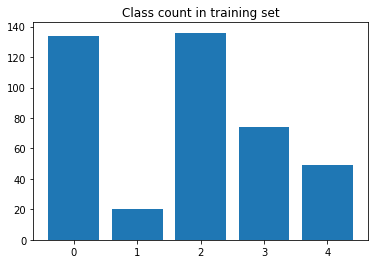

In [0]:
class_count=train_data.Class.value_counts()
class_count1=class_count.to_dict()
count_list = sorted(class_count1.items())

x, y = zip(*count_list) 

plt.title('Class count in training set')
plt.bar(x,y,)
plt.show()

### clearly there is an imbalance in the distribution of samples per class . We will need to take care of this imbalance during training by having more augmented sets for class 1 and also trying to give additional weightage to errors/loss for the small sampled class 

# image pre-processing 

### we can see that the images in the dataset are rectangular with large patches of black along the width . We could crop out these black areas and keep only the retinal image region to remove noise 

In [0]:

from os import listdir
train_data_path='./data/Train/'
test_data_path='./data/Test/'
!mkdir 'resized_img'

In [0]:
train_files = [f for f in listdir(train_data_path)]
test_files=[f for f in listdir(test_data_path)]



In [0]:
!mkdir './resized_img/Train'

### crop and save Train images 

In [0]:

for f in train_files:
  image_path=train_data_path+f
  save_path='./resized_img/Train/'+f
  image=plt.imread(image_path)
  #print(image.shape)
  image2=crop_img(image)
  plt.imsave(save_path,image2)

### plot 5 of the cropped images along with the original image (original image on left and cropped image on right)

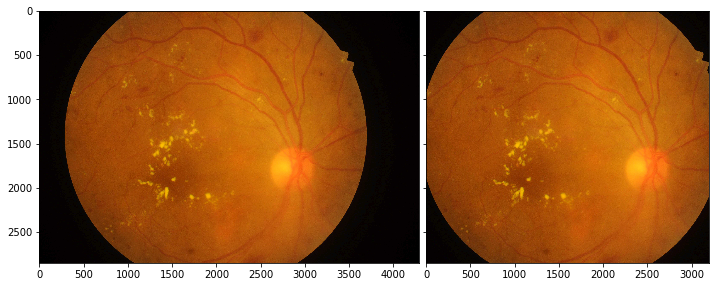

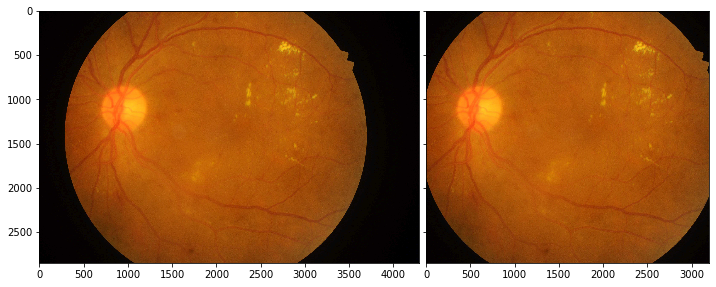

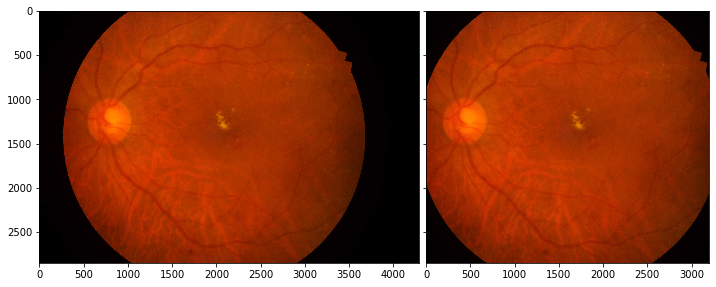

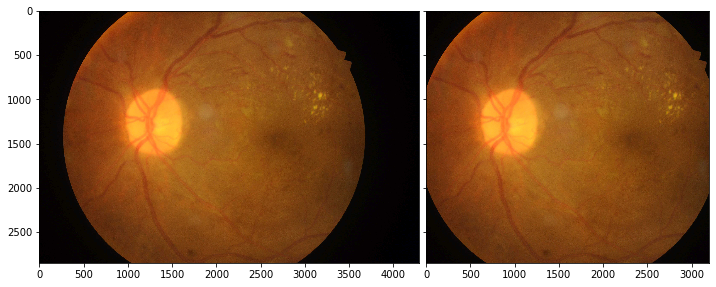

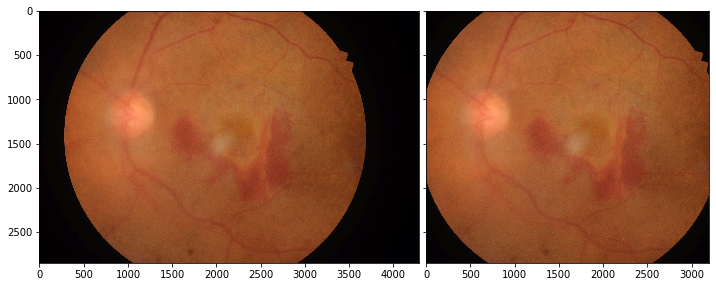

In [143]:
for i in range(5):
  image_path='./data/Train/IDRiD_00'+str(i+1)+'.jpg'
  saved_path='./resized_img/Train/IDRiD_00'+str(i+1)+'.jpg'
  image=plt.imread(image_path)
  #print(image.shape)
  image2=plt.imread(saved_path)
  

  fig = plt.figure(figsize=(12., 12.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  
                 axes_pad=0.1,  # pad between axes in inch.
                 )

  for ax, im in zip(grid, [image, image2]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

  plt.show()

### crop and save test images 

In [0]:
!mkdir './resized_img/Test'

In [0]:
for f in test_files:
  image_path=test_data_path+f
  save_path='./resized_img/Test/'+f
  image=plt.imread(image_path)
  #print(image.shape)
  image2=crop_img(image)
  plt.imsave(save_path,image2)

### Have a first run at training 
1. Create an input image pipeline for traun and test images using ImageDatagenerator using a batchsize of 16 and image size of 284 x 284
2. Create the model : Our first iteration will be a modified Resnet 
3. Compile the model with SGD optimizer 
4 . Train for 100 epochs with a varying learning rate schedule
5. Save the model with best validation accuracy using Model Checkpont calback 

Batch size and EPOCHs

In [0]:
batch_size=16
EPOCHS=100

Define ImageDatagenerators for Train and Test Data . Divide image pixel values by 255 to do pixel-wise normalization. Randomly flip the training image left to right

In [183]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(train_data, directory='./resized_img/Train/', 
                                                    x_col='File', y_col='Class', target_size=(284, 284),
                                                    color_mode='rgb', class_mode='categorical', 
                                                    batch_size=batch_size, shuffle=True, seed=42)



Found 413 validated image filenames belonging to 5 classes.


In [184]:
valid_datagen = ImageDataGenerator(rescale=1./255                                   
                                   )
validation_generator = valid_datagen.flow_from_dataframe(test_data, directory='./resized_img/Test/', 
                                                         x_col='File', y_col='Class', target_size=(284, 284),
                                                    color_mode='rgb', class_mode='categorical', 
                                                    batch_size=batch_size, shuffle=True, seed=42)

Found 103 validated image filenames belonging to 5 classes.


Define regularizers and layer definitions for model 

In [0]:
import math
WEIGHT_DECAY=1.25e-4
reg=tf.keras.regularizers.l2(WEIGHT_DECAY)
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

def conv(inp,f=32,k=3):
  conv_layer=Conv2D(f,k,use_bias=False,padding='same',kernel_initializer=init_pytorch, kernel_regularizer=reg)(inp)
  conv_layer=BatchNormalization(momentum=0.9, epsilon=1e-5)(conv_layer)
  conv_layer=Activation('relu')(conv_layer)
  return conv_layer
def resBlk(inp,f=32,k=3,residual=True) :
  res1=conv(inp,f,k)
  res1=MaxPooling2D(pool_size=(2,2))(res1)
  if residual:
    res2=conv(res1,f,k)
    res3=conv(res2,f,k)
    return res1+res3
  else:
    return res1  

function to build model

In [0]:
def build_model():
  f=64
  inp=Input(shape=(284,284,3))
  layer1=conv(inp,f,3)
  res1=resBlk(layer1,f*2,3)
  
  res2=resBlk(res1,f*4,3,False)
  
  res3=resBlk(res2,f*4,3)

  res4=resBlk(res3,f*8,3,False)

  res5=resBlk(res4,f*8,3)
  
  
  layer2=tf.keras.layers.GlobalMaxPooling2D()(res5)
  layer3=tf.keras.layers.Dense(5, kernel_initializer=init_pytorch, use_bias=False,kernel_regularizer=reg)(layer2)
  layer4=Lambda(lambda x: x*0.125)(layer3)
  out=Activation('softmax')(layer4)
  model=tf.keras.models.Model(inputs=[inp],outputs=[out])
  model.summary()
  return model 

Build Model and print summary 

In [187]:
model=build_model()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 284, 284, 3) 0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 284, 284, 64) 1728        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 284, 284, 64) 256         conv2d_72[0][0]                  
__________________________________________________________________________________________________
activation_77 (Activation)      (None, 284, 284, 64) 0           batch_normalization_72[0][0]     
____________________________________________________________________________________________

Define Learning Rate scheduler 

In [0]:
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule():
    
    def schedule(epoch):
      
      lr=np.interp([epoch],[0, EPOCHS//5,EPOCHS//2,EPOCHS], [0.02, 0.012, 0.008,0.0008])[0]
      print('epoch ', epoch+1, ': setting learning rate to ',lr)
      return lr
    
    return LearningRateScheduler(schedule)

lr_sched = lr_schedule()

Compile Model 

In [0]:
opt=SGD(lr=0.02,momentum=0.9,nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,metrics=['accuracy']
              )

Define ModelCheckpoint callback to save best model

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_cpt=ModelCheckpoint(filepath='/gdrive/My Drive/d-i/retinopathy/best_model.h5', 
                          verbose=1, save_best_only=True,monitor='val_acc',mode='auto')

Train the model for 100 epochs 

In [191]:
EPOCHS=100
model.fit_generator(train_generator, epochs=EPOCHS, 
                        steps_per_epoch=np.ceil(413/batch_size), 
                    validation_data=validation_generator,
                    validation_steps=np.ceil(103/batch_size),
                    shuffle=True,callbacks=[lr_sched,model_cpt],verbose=1)

epoch  1 : setting learning rate to  0.02
Epoch 1/100
 7/26 [=======>......................] - ETA: 1:06 - loss: 1.7126 - acc: 0.3204
Epoch 00001: val_acc improved from -inf to 0.32039, saving model to /gdrive/My Drive/data-incubator/retinopathy/best_model.h5
26/26 [==============================] - 104s 4s/step - loss: 1.5881 - acc: 0.4140 - val_loss: 1.7126 - val_acc: 0.3204
epoch  2 : setting learning rate to  0.0196
Epoch 2/100
 7/26 [=======>......................] - ETA: 59s - loss: 1.6427 - acc: 0.3107 
Epoch 00002: val_acc did not improve from 0.32039
26/26 [==============================] - 63s 2s/step - loss: 1.4974 - acc: 0.4649 - val_loss: 1.6427 - val_acc: 0.3107
epoch  3 : setting learning rate to  0.019200000000000002
Epoch 3/100
 7/26 [=======>......................] - ETA: 58s - loss: 1.6746 - acc: 0.3495 
Epoch 00003: val_acc improved from 0.32039 to 0.34951, saving model to /gdrive/My Drive/data-incubator/retinopathy/best_model.h5
26/26 [=============================

### As we can see, the model was stuck at 58.25% validation accuracy and is clearly overfitting . We need to process the images a bit more and also thing of better augmentation strategies in order to get a better model 

# Revisit Preprocessing strategy 

Let us look at the individual channel information in the images to see if we can just use one of them which has a richer set of information and thereby reducing further noise . 

Let us extract the Red, Green and Blue channels and plot them along with the original image to see which channel contains more contextual information

create new directories for saving processed images 

In [0]:
!mkdir './processed'
!mkdir './processed/Train'
!mkdir './processed/Test'

In [0]:
train_data_path='./resized_img/Train/'
test_data_path='./resized_img/Test/'

define functions to grab red , green and blue channels 

In [0]:
def grab_green(img):
  img1=img.copy()
  img1[:,:,0]=img[:,:,1]
  img1[:,:,2]=img[:,:,1]
  return img1

def grab_red(img):
  img1=img.copy()
  img1[:,:,1]=img[:,:,0]
  img1[:,:,2]=img[:,:,0]
  return img1

def grab_blue(img):
  img1=img.copy()
  img1[:,:,0]=img[:,:,2]
  img1[:,:,1]=img[:,:,2]
  return img1
  

Take a sample of 5 images and plot the original image along with Red , Green and Blue channels 

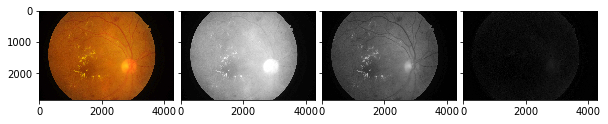

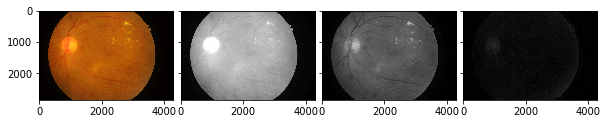

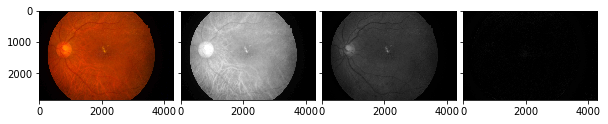

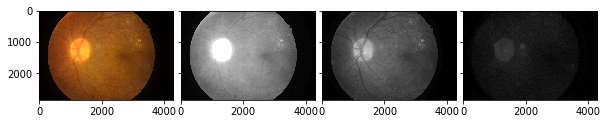

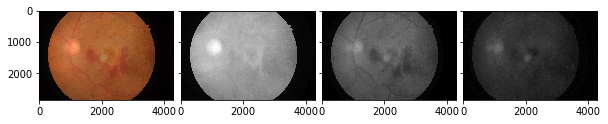

In [202]:
for i in range(5):
  image_path='./IDRiD_00'+str(i+1)+'.jpg'
  
  image=plt.imread(image_path)
  #print(image.shape)
  image2=grab_green(image)
  image3=grab_red(image)
  image4=grab_blue(image)

  

  fig = plt.figure(figsize=(10., 10.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  
                 axes_pad=0.1,  # pad between axes in inch.
                 )

  for ax, im in zip(grid, [image, image3,image2,image4]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

  plt.show()

### We can see that the Red channel is very saturated , Blue doesn't have too much information but the Green channel is rich with information that can be used for training and classifying the images 

Let us save the Green channel and try to train using this set of images . Process and save Train images 

In [0]:

for f in train_files:
  image_path=train_data_path+f
  save_path='./processed/Train/'+f
  image=plt.imread(image_path)
  #print(image.shape)
  image2=grab_green(image)
  plt.imsave(save_path,image2)

### Plot Original image on left , Green Channel on right 

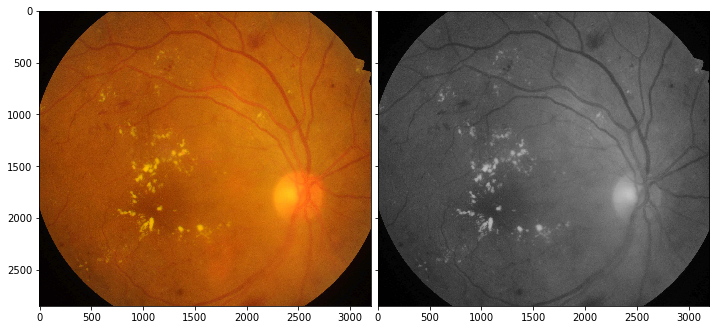

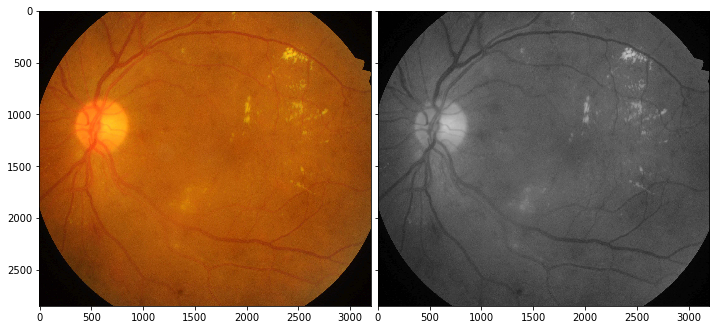

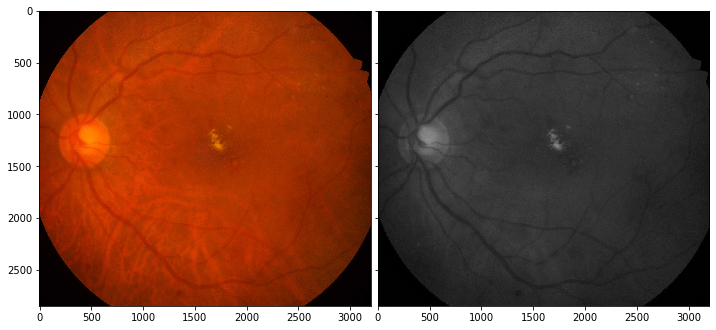

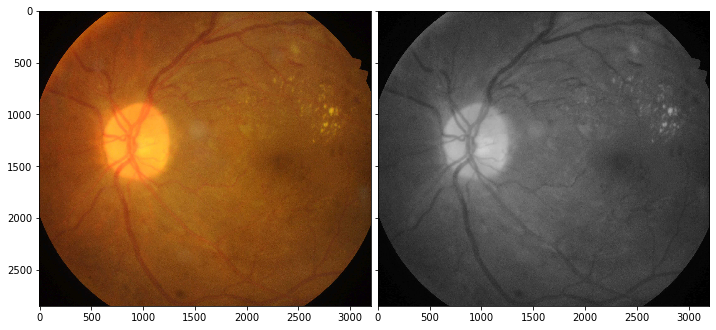

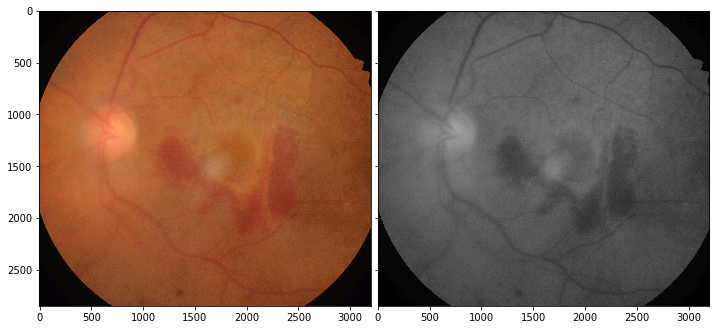

In [198]:
for i in range(5):
  image_path='./resized_img/Train/IDRiD_00'+str(i+1)+'.jpg'
  saved_path='./processed/Train/IDRiD_00'+str(i+1)+'.jpg'
  image=plt.imread(image_path)
  #print(image.shape)
  image2=plt.imread(saved_path)
  

  fig = plt.figure(figsize=(12., 12.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  
                 axes_pad=0.1,  # pad between axes in inch.
                 )

  for ax, im in zip(grid, [image, image2]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

  plt.show()

Process and save Test images 

In [0]:
for f in test_files:
  image_path=test_data_path+f
  save_path='./processed/Test/'+f
  image=plt.imread(image_path)
  #print(image.shape)
  image2=grab_green(image)
  plt.imsave(save_path,image2)

In [0]:
!cp -r './processed' '/gdrive/My Drive/d-i/retinopathy/processed'

### TRain the model again using Green channel images .
Train for 50 epochs to check if we are doing better or worse than the first trial 
Add a few more augmentation techniques like width shift, rotation and height shift to the training images 

Use a LR policy called One-Cycle LR which was made poular by Leslie Smith in his paper describing techniques for SuperConvergence during training - Here we will increase the LR upto some epochs (warm up ) and then start reducing it to a low value 

In [206]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,vertical_flip=True,rotation_range=5,width_shift_range=0.02, height_shift_range=0.02)

train_generator = train_datagen.flow_from_dataframe(train_data, directory='./processed/Train/', 
                                                    x_col='File', y_col='Class', target_size=(284, 284),
                                                    color_mode='rgb', class_mode='categorical', 
                                                    batch_size=batch_size, shuffle=True, seed=42)



Found 413 validated image filenames belonging to 5 classes.


In [207]:
valid_datagen = ImageDataGenerator(rescale=1./255                                   
                                   )
validation_generator = valid_datagen.flow_from_dataframe(test_data, directory='./processed/Test/', 
                                                         x_col='File', y_col='Class', target_size=(284, 284),
                                                    color_mode='rgb', class_mode='categorical', 
                                                    batch_size=batch_size, shuffle=True, seed=42)

Found 103 validated image filenames belonging to 5 classes.


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,metrics=['accuracy']
              )

def lr_schedule():
    
    def schedule(epoch):
      
      lr=np.interp([epoch],[0, EPOCHS//5,EPOCHS//2,EPOCHS], [0.01, 0.06, 0.012,0.0008])[0]
      print('epoch ', epoch+1, ': setting learning rate to ',lr)
      return lr
    
    return LearningRateScheduler(schedule)

lr_sched = lr_schedule()

In [0]:
model_cpt=ModelCheckpoint(filepath='/gdrive/My Drive/d-i/retinopathy/best_model_p1.h5', 
                          verbose=1, save_best_only=True,monitor='val_acc',mode='auto')

In [209]:
EPOCHS=50
model.fit_generator(train_generator, epochs=EPOCHS, 
                        steps_per_epoch=np.ceil(413/batch_size), 
                    validation_data=validation_generator,
                    validation_steps=np.ceil(103/batch_size),
                    shuffle=True,callbacks=[lr_sched,model_cpt],verbose=1)

epoch  1 : setting learning rate to  0.02
Epoch 1/50
 7/26 [=======>......................] - ETA: 1:01 - loss: 2.9227 - acc: 0.3786
Epoch 00001: val_acc improved from -inf to 0.37864, saving model to /gdrive/My Drive/data-incubator/retinopathy/best_model_p1.h5
26/26 [==============================] - 92s 4s/step - loss: 1.8045 - acc: 0.4044 - val_loss: 2.9227 - val_acc: 0.3786
epoch  2 : setting learning rate to  0.019200000000000002
Epoch 2/50
 7/26 [=======>......................] - ETA: 1:01 - loss: 1.5376 - acc: 0.4660
Epoch 00002: val_acc improved from 0.37864 to 0.46602, saving model to /gdrive/My Drive/data-incubator/retinopathy/best_model_p1.h5
26/26 [==============================] - 81s 3s/step - loss: 1.3961 - acc: 0.4867 - val_loss: 1.5376 - val_acc: 0.4660
epoch  3 : setting learning rate to  0.0184
Epoch 3/50
 7/26 [=======>......................] - ETA: 1:01 - loss: 1.7253 - acc: 0.3204
Epoch 00003: val_acc did not improve from 0.46602
26/26 [===========================

### We seem to be doing a little better (using validation accuracy as an indicator) by using the Green channel information for training  

#Next steps 

1. We used a small dataset of 413 training images and 103 test images from https://ieee-dataport.org/open-access/indian-diabetic-retinopathy-image-dataset-idrid  . 

2. We will use a larger dataset like the one in https://www.kaggle.com/c/diabetic-retinopathy-detection/data or Messidor / Messidor2 datasets for further training and building a better model 

3. We could then use this Model on various pltforms including mobile phones (using Tensorflow lite ) such that it can be used in remote areas where a primary health center with facility to capture retinal image can use it for preliminary screening 